In [1]:

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/aitxdil-project-jupyter/sampleSubmission.csv
/kaggle/input/aitxdil-project-jupyter/Cleaned_Training_Data/Cleaned_Training_Data/94.png
/kaggle/input/aitxdil-project-jupyter/Cleaned_Training_Data/Cleaned_Training_Data/48.png
/kaggle/input/aitxdil-project-jupyter/Cleaned_Training_Data/Cleaned_Training_Data/61.png
/kaggle/input/aitxdil-project-jupyter/Cleaned_Training_Data/Cleaned_Training_Data/37.png
/kaggle/input/aitxdil-project-jupyter/Cleaned_Training_Data/Cleaned_Training_Data/35.png
/kaggle/input/aitxdil-project-jupyter/Cleaned_Training_Data/Cleaned_Training_Data/70.png
/kaggle/input/aitxdil-project-jupyter/Cleaned_Training_Data/Cleaned_Training_Data/73.png
/kaggle/input/aitxdil-project-jupyter/Cleaned_Training_Data/Cleaned_Training_Data/92.png
/kaggle/input/aitxdil-project-jupyter/Cleaned_Training_Data/Cleaned_Training_Data/75.png
/kaggle/input/aitxdil-project-jupyter/Cleaned_Training_Data/Cleaned_Training_Data/89.png
/kaggle/input/aitxdil-project-jupyter/Cleaned_Train

In [2]:
import glob
import cv2

#cleaned_training_data
cleaned_directory_path = "/kaggle/input/aitxdil-project-jupyter/Cleaned_Training_Data/Cleaned_Training_Data/"

cleaned_file_paths = glob.glob(cleaned_directory_path + "*.png")

cleaned_images = []
for file_path in cleaned_file_paths:
    image = cv2.imread(file_path)
    cleaned_images.append(image)

#training_data
training_directory_path = "/kaggle/input/aitxdil-project-jupyter/Training_Data/Training_Data/"

training_file_paths = glob.glob(training_directory_path + "*.png")

training_images = []
for file_path in training_file_paths:
    image = cv2.imread(file_path)
    training_images.append(image)
    
#test_data
test_directory_path = "/kaggle/input/aitxdil-project-jupyter/Test_Data/Test_Data/"

test_file_paths = glob.glob(test_directory_path + "*.png")

test_images = []
for file_path in test_file_paths:
    image = cv2.imread(file_path)
    test_images.append(image)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img

import imageio
import imgaug as ia
from imgaug import augmenters as iaa

from keras.preprocessing import image
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D, LeakyReLU
from keras.layers import MaxPooling2D, Dropout, UpSampling2D
from keras import regularizers
import keras.backend as kb
from tensorflow.keras.preprocessing import image
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 5.0) # set default size of plots


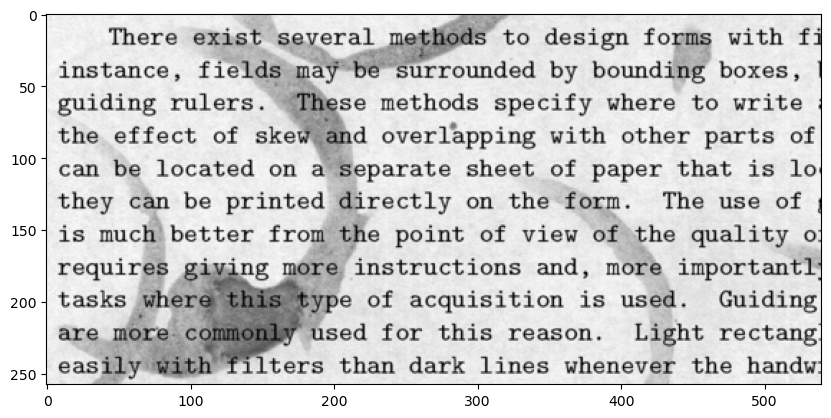

In [4]:
bsb = img.imread('/kaggle/input/aitxdil-project-jupyter/Training_Data/Training_Data/70.png')
plt.imshow(bsb, cmap=plt.cm.gray)

In [5]:
target_width = 540
target_height = 256

In [6]:
def load_image_from_dir(img_path):
    file_list = glob.glob(img_path+'/*.png')
    file_list.sort()
    img_list = np.empty((len(file_list), target_height, target_width, 1))
    for i, fig in enumerate(file_list):
        img = image.load_img(fig, color_mode='grayscale', target_size=(target_height, target_width))
        img_array = image.img_to_array(img).astype('float32')
        img_array = img_array / 255.0
        img_list[i] = img_array
    
    return img_list

def train_test_split(data,random_seed=55,split=0.75):
    set_rdm = np.random.RandomState(seed=random_seed)
    dsize = len(data)
    ind = set_rdm.choice(dsize,dsize,replace=False)
    train_ind = ind[:int(0.75*dsize)]
    val_ind = ind[int(0.75*dsize):]
    return data[train_ind],data[val_ind]

def augment_pipeline(pipeline, images, seed=5):
    ia.seed(seed)
    processed_images = images.copy()
    for step in pipeline:
        temp = np.array(step.augment_images(images))
        processed_images = np.append(processed_images, temp, axis=0)
    return(processed_images)

In [7]:
full_train = load_image_from_dir('/kaggle/input/aitxdil-project-jupyter/Training_Data/Training_Data')
full_target = load_image_from_dir('/kaggle/input/aitxdil-project-jupyter/Cleaned_Training_Data/Cleaned_Training_Data')

In [8]:
rotate90 = iaa.Rot90(1) # rotate image 90 degrees
rotate180 = iaa.Rot90(2) # rotate image 180 degrees
rotate270 = iaa.Rot90(3) # rotate image 270 degrees
random_rotate = iaa.Rot90((1,3)) # randomly rotate image from 90,180,270 degrees
perc_transform = iaa.PerspectiveTransform(scale=(0.02, 0.1)) # Skews and transform images without black bg
rotate10 = iaa.Affine(rotate=(10)) # rotate image 10 degrees
rotate10r = iaa.Affine(rotate=(-10)) # rotate image 30 degrees in reverse
crop = iaa.Crop(px=(5, 32)) # Crop between 5 to 32 pixels
hflip = iaa.Fliplr(1) # horizontal flips for 100% of images
vflip = iaa.Flipud(1) # vertical flips for 100% of images
gblur = iaa.GaussianBlur(sigma=(1, 1.5)) # gaussian blur images with a sigma of 1.0 to 1.5
motionblur = iaa.MotionBlur(8) # motion blur images with a kernel size 8

seq_rp = iaa.Sequential([
    iaa.Rot90((1,3)), # randomly rotate image from 90,180,270 degrees
    iaa.PerspectiveTransform(scale=(0.02, 0.1)) # Skews and transform images without black bg
])

seq_cfg = iaa.Sequential([
    iaa.Crop(px=(5, 32)), # crop images from each side by 5 to 32px (randomly chosen)
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.GaussianBlur(sigma=(0, 1.5)) # blur images with a sigma of 0 to 1.5
])

seq_fm = iaa.Sequential([
    iaa.Flipud(1), # vertical flips all the images
    iaa.MotionBlur(k=6) # motion blur images with a kernel size 6
])

In [9]:
pipeline = []
pipeline.append(rotate90)
pipeline.append(rotate180)
pipeline.append(rotate270)
# pipeline.append(random_rotate)
pipeline.append(perc_transform)
# pipeline.append(rotate10)
# pipeline.append(rotate10r)
pipeline.append(crop)
pipeline.append(hflip)
pipeline.append(vflip)
# pipeline.append(gblur)
# pipeline.append(motionblur)
pipeline.append(seq_rp)
pipeline.append(seq_cfg)
pipeline.append(seq_fm)

In [10]:
%%time
processed_train = augment_pipeline(pipeline, full_train.reshape(-1,target_height,target_width))
processed_target = augment_pipeline(pipeline, full_target.reshape(-1,target_height,target_width))

processed_train = processed_train.reshape(-1,target_height,target_width,1)
processed_target = processed_target.reshape(-1,target_height,target_width,1)

processed_train.shape

CPU times: user 7.99 s, sys: 4.76 s, total: 12.7 s
Wall time: 10.5 s


(1100, 256, 540, 1)

In [11]:
### Multi layer auto encoder with LeakyRelu and Normalization
input_layer = Input(shape=(None,None,1))

# encoder
e = Conv2D(32, (3, 3), padding='same')(input_layer)
e = LeakyReLU(alpha=0.3)(e)
e = BatchNormalization()(e)
e = Conv2D(64, (3, 3), padding='same')(e)
e = LeakyReLU(alpha=0.3)(e)
e = BatchNormalization()(e)
e = Conv2D(64, (3, 3), padding='same')(e)
e = LeakyReLU(alpha=0.3)(e)
e = MaxPooling2D((2, 2), padding='same')(e)

# decoder
d = Conv2D(64, (3, 3), padding='same')(e)
d = LeakyReLU(alpha=0.3)(d)
d = BatchNormalization()(d)

d = Conv2D(64, (3, 3), padding='same')(d)
d = LeakyReLU(alpha=0.3)(d)
# e = BatchNormalization()(e)
d = UpSampling2D((2, 2))(d)
d = Conv2D(32, (3, 3), padding='same')(d)
d = LeakyReLU(alpha=0.2)(d)
# d = Conv2D(128, (3, 3), padding='same')(d)
output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(d)

In [12]:
# optimizer = Adam(lr=1e-4, decay=7e-6)
optimizer = Adam(lr=9e-4, decay=1e-5)
AEmodel = Model(input_layer,output_layer)
AEmodel.compile(loss='mse', optimizer=optimizer)
AEmodel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 32)    320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, None, None, 32)    0         
                                                                 
 batch_normalization (BatchN  (None, None, None, 32)   128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, None, None, 64)    0         
                                                             

/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [13]:
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=30,
                               verbose=1, 
                               mode='auto')

checkpoint1 = ModelCheckpoint('best_val_loss.h5',
                             monitor='val_loss',
                             save_best_only=True)

checkpoint2 = ModelCheckpoint('best_loss.h5',
                             monitor='loss',
                             save_best_only=True)

In [14]:
history = AEmodel.fit(processed_train, processed_target,
                      batch_size=16,
                      epochs=300,
                       validation_split=0.2,
                      callbacks=[checkpoint2])

Epoch 1/300
55/55 [==============================] - 24s 305ms/step - loss: 0.0113 - val_loss: 0.0475
Epoch 2/300
55/55 [==============================] - 16s 284ms/step - loss: 0.0039 - val_loss: 0.0475
Epoch 3/300
55/55 [==============================] - 16s 284ms/step - loss: 0.0030 - val_loss: 0.0474
Epoch 4/300
55/55 [==============================] - 16s 283ms/step - loss: 0.0025 - val_loss: 0.0473
Epoch 5/300
55/55 [==============================] - 16s 284ms/step - loss: 0.0022 - val_loss: 0.0468
Epoch 6/300
55/55 [==============================] - 16s 283ms/step - loss: 0.0021 - val_loss: 0.0449
Epoch 7/300
55/55 [==============================] - 16s 283ms/step - loss: 0.0020 - val_loss: 0.0421
Epoch 8/300
55/55 [==============================] - 16s 283ms/step - loss: 0.0019 - val_loss: 0.0318
Epoch 9/300
55/55 [==============================] - 16s 284ms/step - loss: 0.0017 - val_loss: 0.0257
Epoch 10/300
55/55 [==============================] - 16s 283ms/step - loss: 0.001

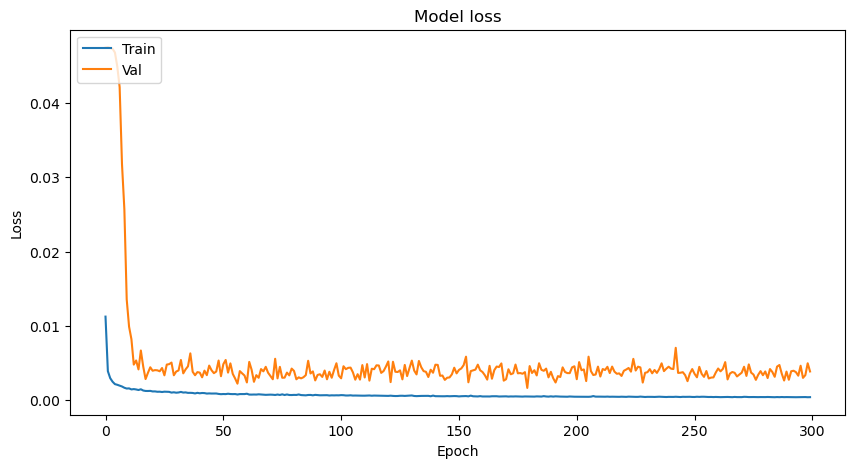

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Val'], loc='upper left')
plt.show()

In [16]:
AEmodel.save('AutoEncoderModelFull.h5')

In [17]:
# full_model_preds = AEmodel.predict(test)
full_train_preds = AEmodel.predict(full_train)

AEmodel.load_weights('best_loss.h5')
AEmodel.compile(loss='mse', optimizer=optimizer)
# preds = AEmodel.predict(test)
train_preds = AEmodel.predict(full_train)

4/4 [==============================] - 1s 154ms/step


In [18]:
AEmodel.evaluate(full_train, full_target)

4/4 [==============================] - 1s 117ms/step - loss: 3.4381e-04


0.00034381166915409267

In [19]:
AEmodel.save('AutoEncoderModelBestLoss.h5')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
  """Entry point for launching an IPython kernel.


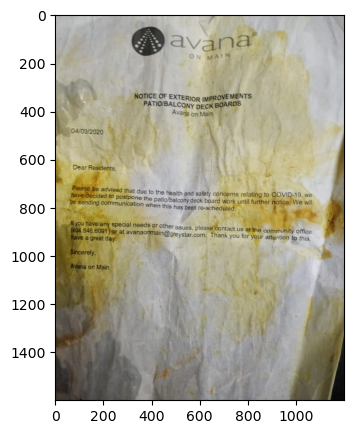

In [20]:
bsb = img.imread('https://github.com/sampath9dasari/GSU/raw/master/denoise_test.png')
# test = img.imread('../kaggle/working/test/1.png')
plt.imshow(bsb, cmap=plt.cm.gray)


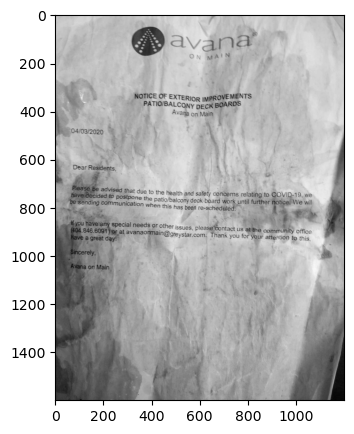

In [21]:
# ii = cv2.imread("https://github.com/sampath9dasari/GSU/raw/master/denoise_test.png")
gray_image = cv2.cvtColor(bsb, cv2.COLOR_BGR2GRAY)
# print(gray_image)
plt.imshow(gray_image,cmap=plt.cm.gray)
plt.show()

In [22]:
gpred = AEmodel.predict(gray_image.reshape(1,1599,1200,1))

1/1 [==============================] - 1s 898ms/step


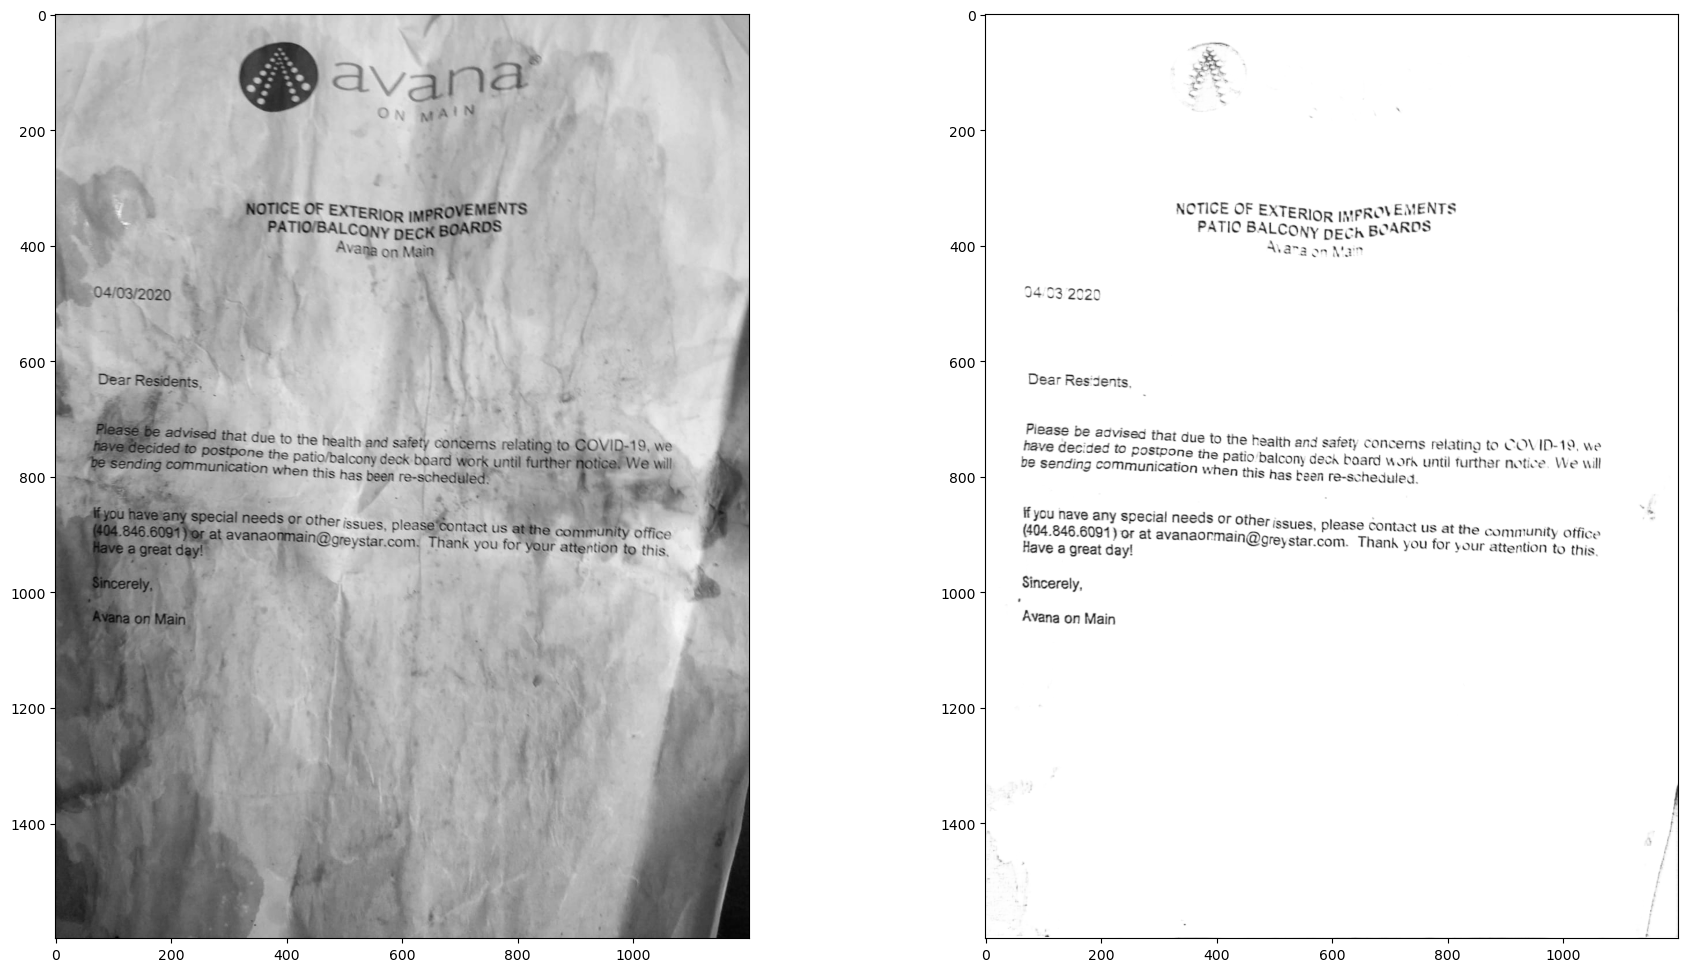

In [23]:
fig, ax = plt.subplots(1,2,figsize=(22,12))
ax[0].imshow(gray_image, cmap=plt.cm.gray)
ax[1].imshow(gpred.reshape(1600,1200), cmap=plt.cm.gray)

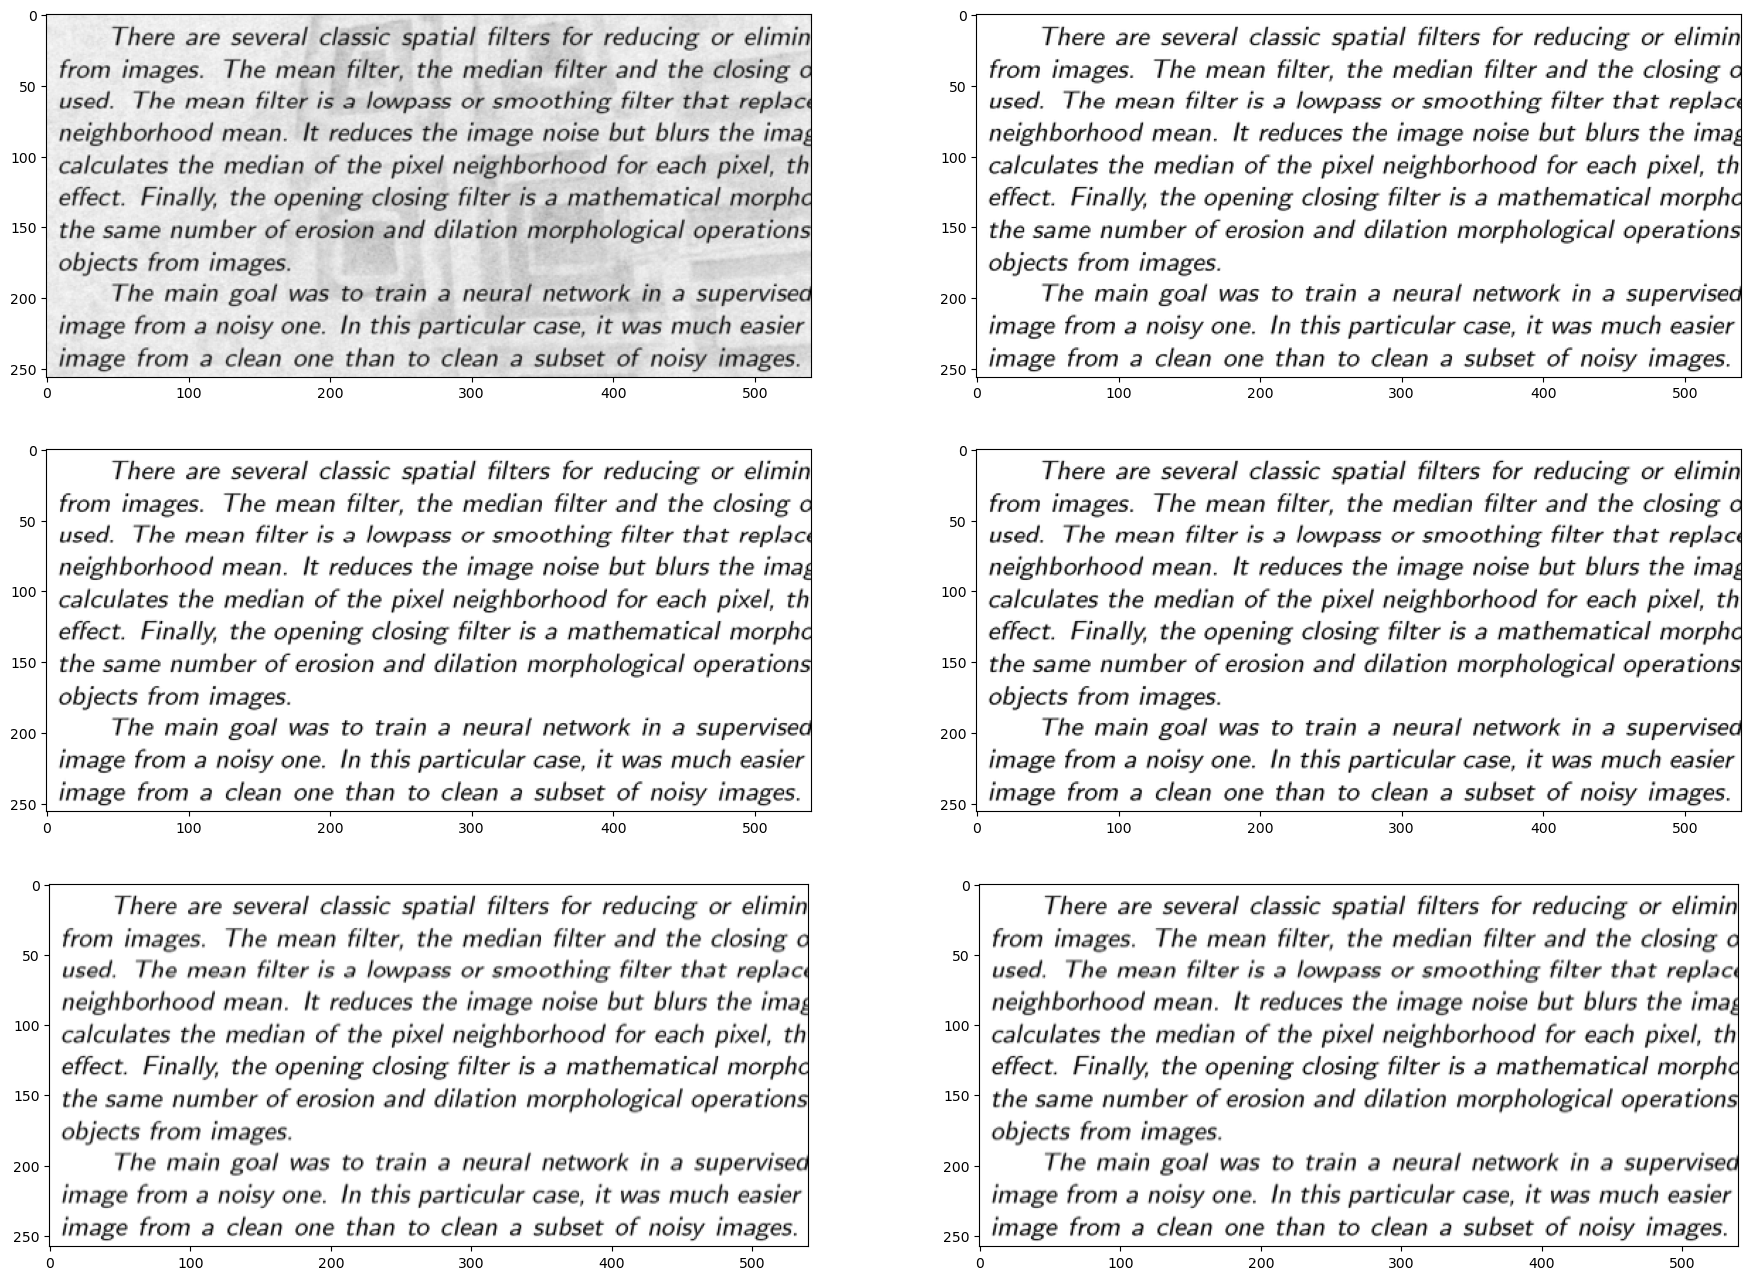

In [24]:
fig, ax = plt.subplots(3,2,figsize=(22,16))
ax[0][0].imshow(full_train[42].reshape(target_height,target_width), cmap=plt.cm.gray)
ax[0][1].imshow(full_target[42].reshape(target_height,target_width), cmap=plt.cm.gray)
ax[1][0].imshow(full_train_preds[42].reshape(target_height,target_width), cmap=plt.cm.gray)
ax[1][1].imshow(train_preds[42].reshape(target_height,target_width), cmap=plt.cm.gray)
reshape = cv2.resize(full_train_preds[42],(target_width,258))
ax[2][0].imshow(reshape.reshape(258,target_width), cmap=plt.cm.gray)
reshape = cv2.resize(train_preds[42],(target_width,258))
ax[2][1].imshow(reshape.reshape(258,target_width), cmap=plt.cm.gray)

In [25]:
#Load and Scale test images into one big list.
file_list = glob.glob('/kaggle/input/aitxdil-project-jupyter/Test_Data/Test_Data/*.png')
file_list.sort()
test_size = len(file_list)

#initailize data arrays.
img_ids = []
test = []

#read data
for i, img_dir in enumerate(file_list):
    file = os.path.basename(img_dir)
    imgid = int(file[:-4])
    img_ids.append(imgid)
    img_pixels = image.load_img(img_dir, color_mode='grayscale')
    w, h = img_pixels.size
    test.append(np.array(img_pixels).reshape(1, h, w, 1) / 256.)
    
print('Test sample shape: ', test[0].shape)
print('Test sample dtype: ', test[0].dtype)

Test sample shape:  (1, 420, 540, 1)
Test sample dtype:  float64


In [26]:
file_list = glob.glob('/kaggle/input/aitxdil-project-jupyter/Test_Data/Test_Data/43.png')
print(file_list)

['/kaggle/input/aitxdil-project-jupyter/Test_Data/Test_Data/43.png']


In [27]:
#Predict test images one by one and store them into a list.
test_preds = []
for img in test:
    test_preds.append(AEmodel.predict(img)[0, :, :, 0])

1/1 [==============================] - 0s 22ms/step


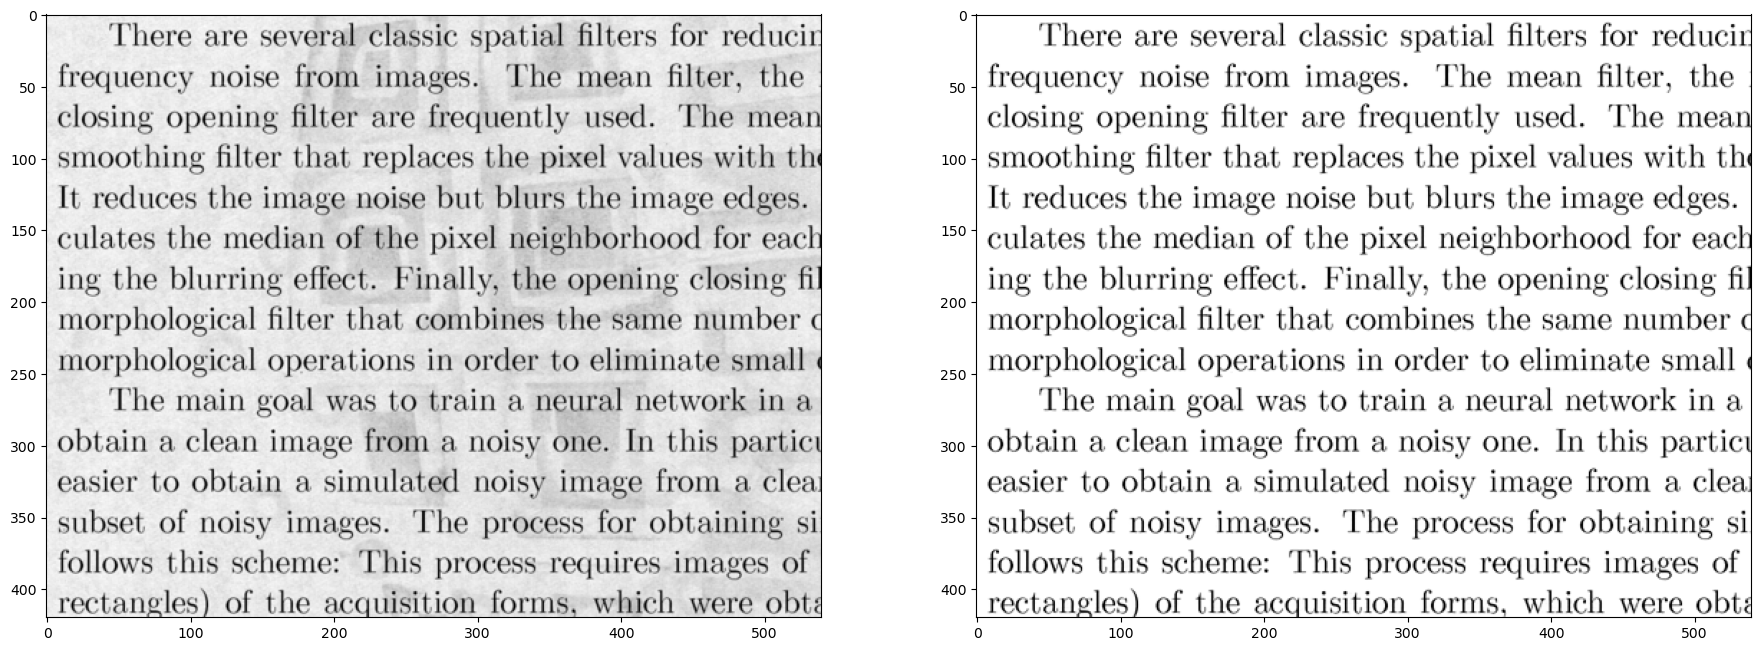

In [28]:
fig, ax = plt.subplots(1,2,figsize=(22,12))
ax[0].imshow(test[43].reshape(test[43].shape[1],test[43].shape[2]), cmap=plt.cm.gray)
ax[1].imshow(test_preds[43].reshape(test[43].shape[1],test[43].shape[2]), cmap=plt.cm.gray)

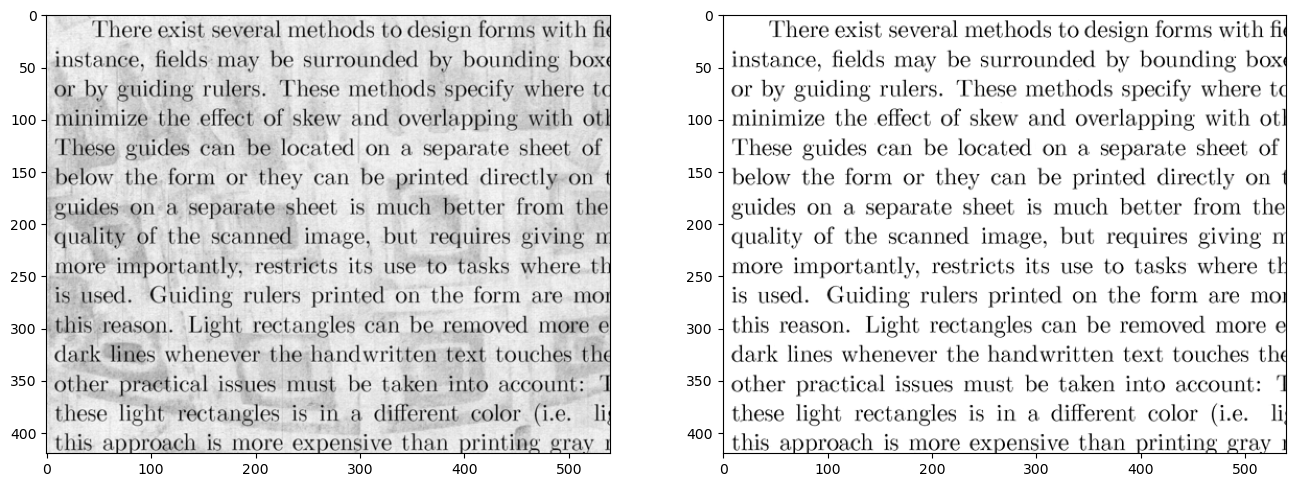

In [29]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
ax[0].imshow(test[42].reshape(test[42].shape[1],test[42].shape[2]), cmap=plt.cm.gray)
ax[1].imshow(test_preds[42].reshape(test[42].shape[1],test[42].shape[2]), cmap=plt.cm.gray)

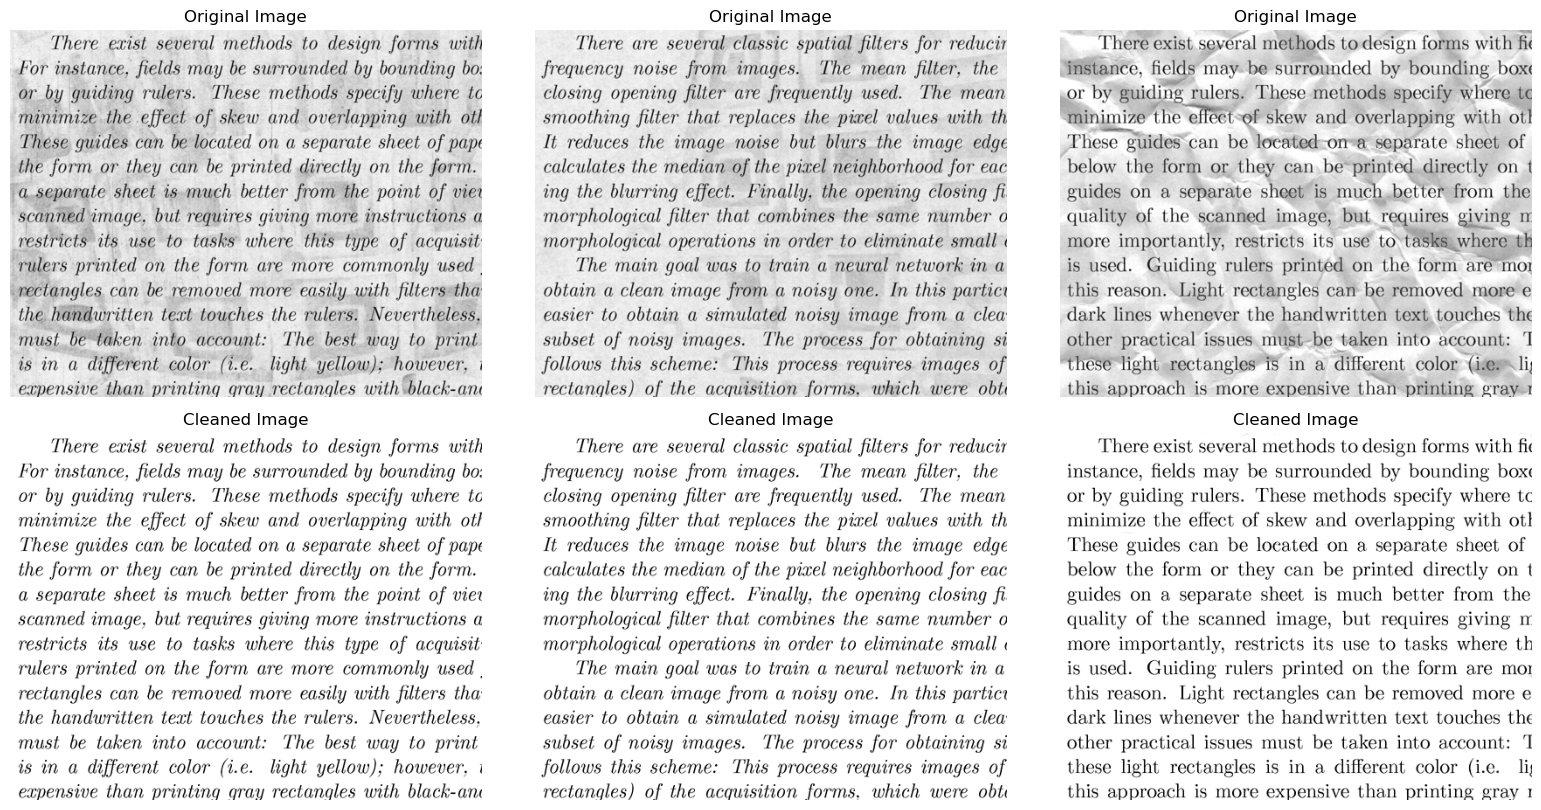

In [30]:
# First column will be raw data, second column will be the corresponding cleaned images.
f, ax = plt.subplots(2,3, figsize=(20,10))
f.subplots_adjust(hspace = .1, wspace=.05)
for i, (img, lbl) in enumerate(zip(test[:3], test_preds[:3])):
    ax[0, i].imshow(img[0,:,:,0], cmap='gray')
    ax[0, i].title.set_text('Original Image')
    ax[0, i].axis('off')

    ax[1, i].imshow(lbl, cmap='gray')
    ax[1, i].title.set_text('Cleaned Image')
    ax[1, i].axis('off')
plt.show()

In [31]:
#Flatten the 'test_preds' list into 1-d list for submission.
submit_vector = []
submit_ids = []
for imgid, img in zip(img_ids,test_preds):
    h, w = img.shape
    for c in range(w):
        for r in range(h):
            submit_ids.append(str(imgid+1)+'_'+str(r + 1)+'_'+str(c + 1))
            submit_vector.append(img[r,c])
print(len(submit_vector))

9979200


In [32]:
len(submit_vector)

9979200

In [33]:
sample_csv = pd.read_csv('/kaggle/input/aitxdil-project-jupyter/sampleSubmission.csv')
sample_csv.head(10)

id  value
0   1_1_1      1
1   1_2_1      1
2   1_3_1      1
3   1_4_1      1
4   1_5_1      1
5   1_6_1      1
6   1_7_1      1
7   1_8_1      1
8   1_9_1      1
9  1_10_1      1

In [34]:
id_col = pd.Series(submit_ids, name = 'id')
value_col = pd.Series(submit_vector, name='value')
submission = pd.concat([id_col, value_col], axis=1)
submission.head(10)

id     value
0   1_1_1  0.985299
1   1_2_1  0.998672
2   1_3_1  0.997400
3   1_4_1  0.998804
4   1_5_1  0.999518
5   1_6_1  0.999664
6   1_7_1  0.999383
7   1_8_1  0.999413
8   1_9_1  0.999576
9  1_10_1  0.999526

In [35]:
submission.isna().sum()

id       0
value    0
dtype: int64

In [36]:
submission.to_csv('submission.csv',index = False)